In [19]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt 
import rasterio
from matplotlib.patches import Rectangle
from shapely.geometry import box, Point

In [20]:
df=pd.read_csv(r"C:\Users\rishi\ml_projects\climate\lat_long_label_4_points.csv")
df

,LAT,LON
0,17.3775,78.04750
1,17.3825,78.04750
2,17.3775,78.05251
3,17.3325,78.06250
4,17.3375,78.06250
...,...,...
2545,17.5225,78.89750
2546,17.5325,78.89750
2547,17.2525,78.90250
2548,17.4625,78.92250


<Axes: >

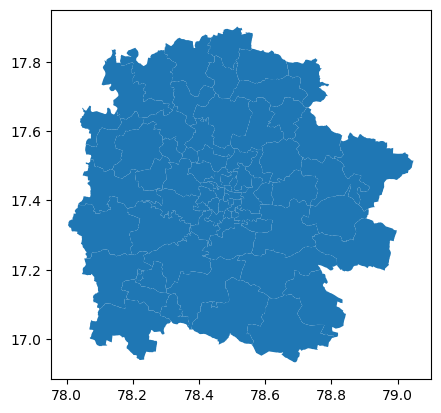

In [21]:
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)
gdf.plot()

In [22]:
gdf_points = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df['LON'], df['LAT']),
    crs="EPSG:4326"  # Set the coordinate reference system (WGS84)
)

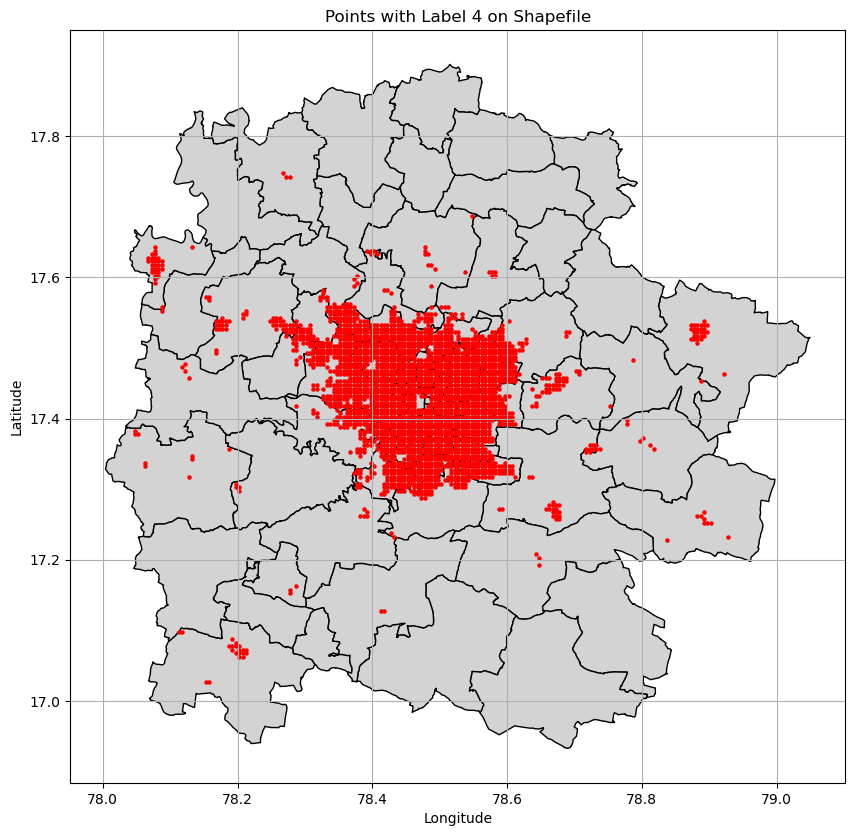

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the shapefile (base map)
gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the points on top of the shapefile
gdf_points.plot(ax=ax, color='red', markersize=5)

# Customize plot
plt.title("Points with Label 4 on Shapefile")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Show plot
plt.show()

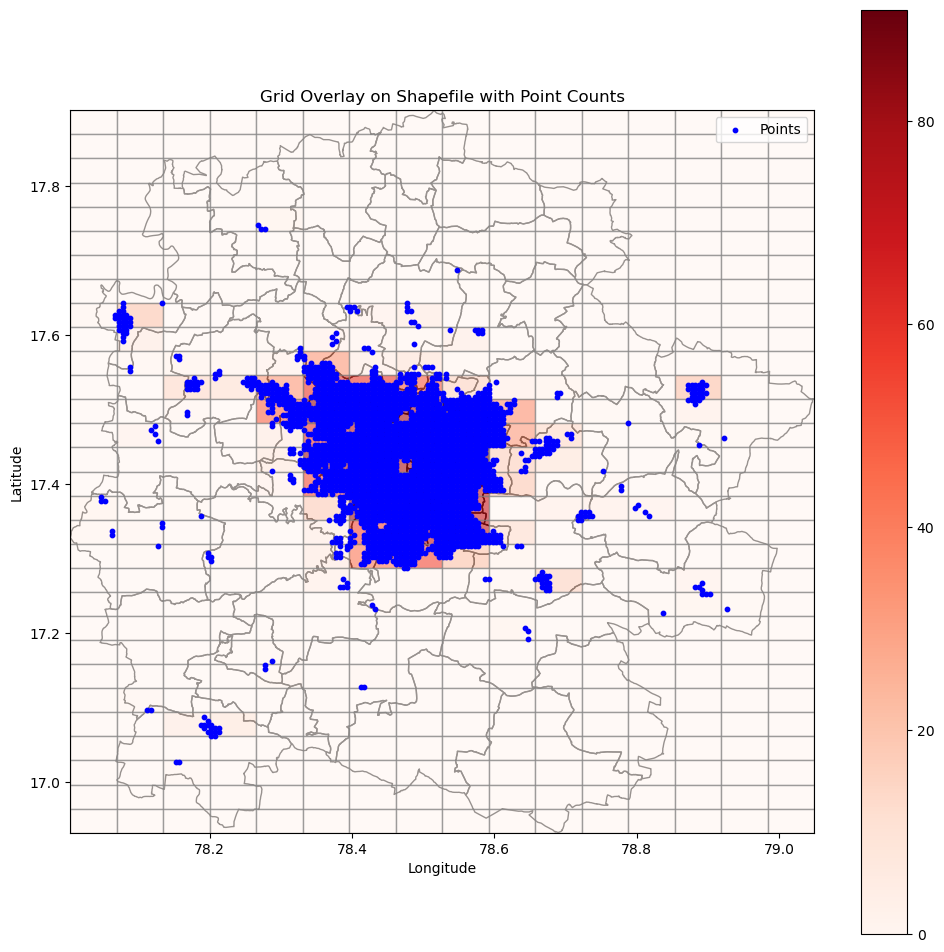

In [24]:
tiff_path = r'C:\Users\rishi\ml_projects\climate\Notebooks\data\HCHO\3945cee2f635794be3a53294f245b6de\response.tiff'
with rasterio.open(tiff_path) as src:
    bounds = src.bounds
    width = src.width
    height = src.height
    transform = src.transform

# Load the shapefile
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
shape_data = gpd.read_file(shapefile_path)

# Create a sample points GeoDataFrame (replace with your actual points data)
points = [Point(78.5, 17.4), Point(78.6, 17.5), Point(78.5, 17.6)]  # Example points
points_gdf = gdf_points

# Generate grid cells as polygons
grid_cells = []
for row in range(height):
    for col in range(width):
        x = transform[2] + col * transform[0]
        y = transform[5] + row * transform[4]
        cell = box(x, y + transform[4], x + transform[0], y)  # Create a grid cell as a polygon
        grid_cells.append(cell)

# Create a GeoDataFrame for the grid cells
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs='EPSG:4326')

# Perform a spatial join to count points in each grid cell
joined = gpd.sjoin(points_gdf, grid_gdf, how='inner', predicate='within')

# Count points in each grid cell
point_counts = joined.groupby('index_right').size()
grid_gdf['point_count'] = grid_gdf.index.map(point_counts).fillna(0)

# Plotting the shapefile and the grid
fig, ax = plt.subplots(figsize=(12, 12))
shape_data.plot(ax=ax, color='none', edgecolor='black')

# Plot the grid with colors based on point counts
grid_gdf.plot(ax=ax, column='point_count', cmap='Reds', edgecolor='gray', alpha=0.6, legend=True)

# Plot the points
points_gdf.plot(ax=ax, color='blue', markersize=10, label='Points')

# Set plot limits
ax.set_xlim(bounds.left, bounds.right)
ax.set_ylim(bounds.bottom, bounds.top)

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Grid Overlay on Shapefile with Point Counts')

plt.legend()
plt.show()

In [25]:
y=grid_gdf['geometry'].tolist()
y

[<POLYGON ((78.069 17.869, 78.069 17.902, 78.004 17.902, 78.004 17.869, 78.06...>,
 <POLYGON ((78.135 17.869, 78.135 17.902, 78.069 17.902, 78.069 17.869, 78.13...>,
 <POLYGON ((78.2 17.869, 78.2 17.902, 78.135 17.902, 78.135 17.869, 78.2 17.8...>,
 <POLYGON ((78.265 17.869, 78.265 17.902, 78.2 17.902, 78.2 17.869, 78.265 17...>,
 <POLYGON ((78.331 17.869, 78.331 17.902, 78.265 17.902, 78.265 17.869, 78.33...>,
 <POLYGON ((78.396 17.869, 78.396 17.902, 78.331 17.902, 78.331 17.869, 78.39...>,
 <POLYGON ((78.462 17.869, 78.462 17.902, 78.396 17.902, 78.396 17.869, 78.46...>,
 <POLYGON ((78.527 17.869, 78.527 17.902, 78.462 17.902, 78.462 17.869, 78.52...>,
 <POLYGON ((78.592 17.869, 78.592 17.902, 78.527 17.902, 78.527 17.869, 78.59...>,
 <POLYGON ((78.658 17.869, 78.658 17.902, 78.592 17.902, 78.592 17.869, 78.65...>,
 <POLYGON ((78.723 17.869, 78.723 17.902, 78.658 17.902, 78.658 17.869, 78.72...>,
 <POLYGON ((78.788 17.869, 78.788 17.902, 78.723 17.902, 78.723 17.869, 78.78...>,
 <PO

In [26]:
x=grid_gdf['point_count'].to_numpy()
x=x[x!=0]
x.shape

(107,)

In [27]:

np.savetxt('points_arr.csv',x)